In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats as stats

import pymc3 as pm

%matplotlib nbagg

np.random.seed(12345)

# Бейсов извод /Bayesian Inference/ с PyMC3

Целта на статистическия извод е да намери измежду предварително избрани разпределения, това,
което най-добре описва данните. Ако данните ни са дефинирани в област $X$, то може да запишем избраните 
дистрибуции като фамилия:
    $$\mathcal{F} = \{\mathcal{F}_\mu(x): \mu \in \Omega, x \in X\}$$
    
Където параметъра $\mu \in \Omega$ параметризира различните разпределения $\mathcal{F}_\mu(x)$. $\mu$ може да е
едномерно, многомерно, непрекъснато, дискретно. Например за стандартното нормално разпределение имаме два параметъра, които го описват: очакшането $E(X)=\theta$ и дисперсията $var(X)=\sigma^2$. T.e. $\mu = (\theta, \sigma^2)$, а $\Omega = (-\infty, +\infty)\times [0, +\infty)$.

Този подход е валиден за класическите фрикуентистки изводи, които правихме до сега, както и за Бейсовия подход, който предстои да разгледаме.

## Пример за Бейсов извод с процес на Бернули
Нека разгледаме процес на Бернули с параметър $\mu$.

Вероятност за успех $P(x=1)=\mu$

Вероятност за неуспех $P(x=0)=1-\mu$

Вектор от 100 наблюдения:

$ x = (x_i)_{i=1}^{100}$

In [40]:
mu = 0.6
size = 100

x = stats.bernoulli.rvs(mu, size=size)
print('x =', x)

x = [1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1
 1 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1
 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1]


### Оценка с максимална правдоподобност /Maximum Likelihood Estimate/

In [41]:
np.mean(x)

0.54000000000000004

### Бейсов подход

In [42]:
class UpdateDist(object):
    def __init__(self, ax, data, prob, alpha=1, beta=1):
        """Sets up the animation of updated posteriors for a Bernoulli process with
        data drawn from data and prior distributed as Beta(alpha, beta)"""
        self.data = data
        self.alpha=alpha
        self.beta=beta
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='blue')

    def start(self):
        self.line.set_data(self.x, stats.beta.pdf(self.x, self.alpha, self.beta))
        return self.line,

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            return self.start()
        
        y = stats.beta.pdf(self.x, np.sum(X[:i]) + self.alpha, (i - np.sum(X[:i]) ) + self.beta)
        self.line.set_data(self.x, y)
        return self.line,


В Бейсовия подход преди да започнем да анализираме данните, предлагаме разпределение, което да отразява предварителните ни вярвания за параметъра $\mu$. В случая ще предположим, че априори разпределението $g(\mu)$
e разпределено Beta(alpha, beta). alpha и beta са метапараметри на модела. Различните им стойности дават голямо разнообразие от модели за априори. Например при alpaha=beta=1 се получава равномерно разпределение в (0,1).

<IPython.core.display.Javascript object>


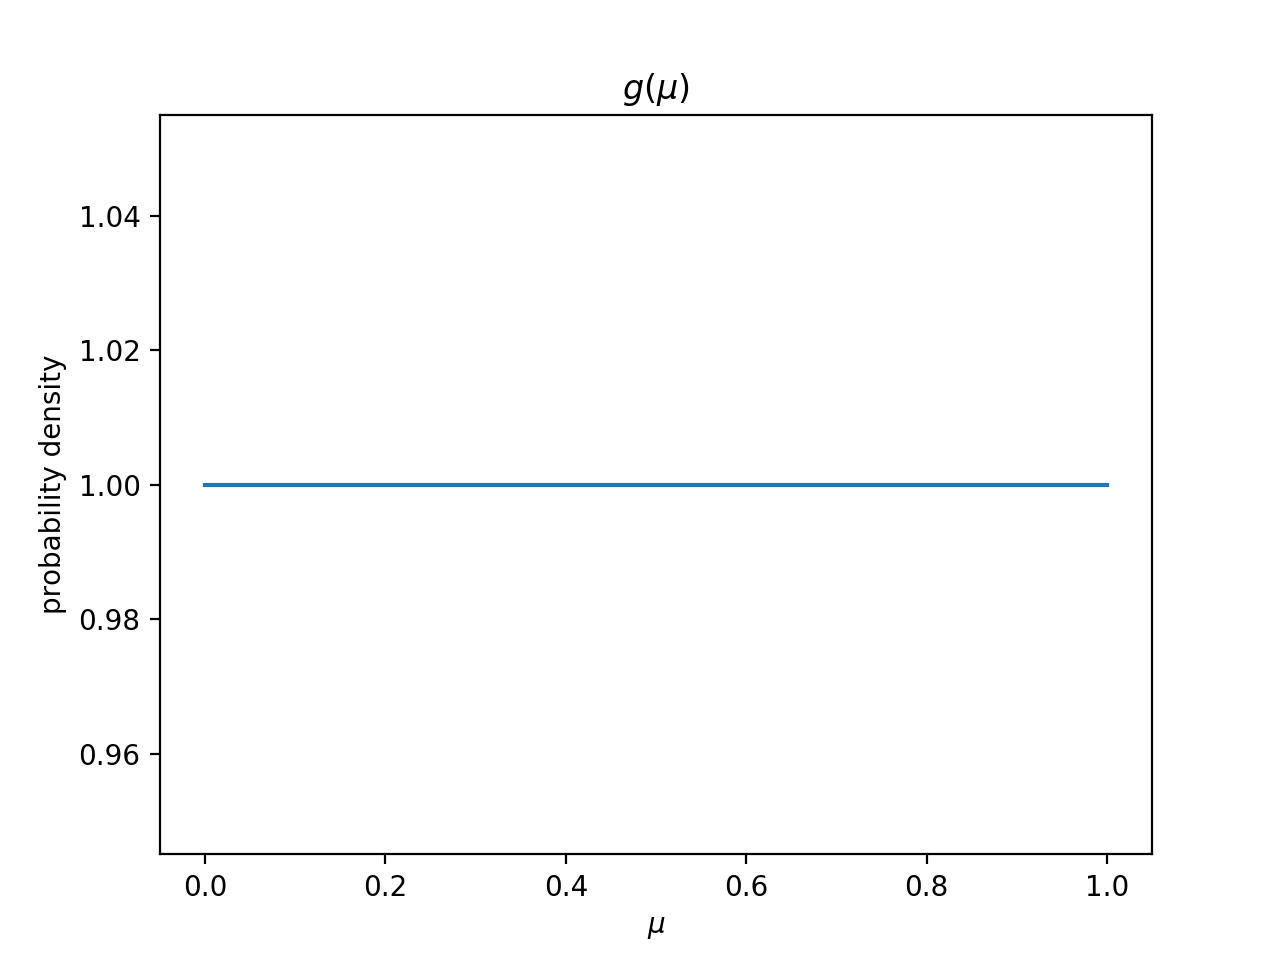

Text(0.5,0,'$\\mu$')

In [45]:
alpha = 1
beta = 1

x = np.linspace(0,1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta))
plt.title('$g(\mu)$')
plt.ylabel('probability density')
plt.xlabel(r'$\mu$')

Стартирайки с първоначалното предположение, обновяваме нашите виждания след всяко наблюдение.

<IPython.core.display.Javascript object>


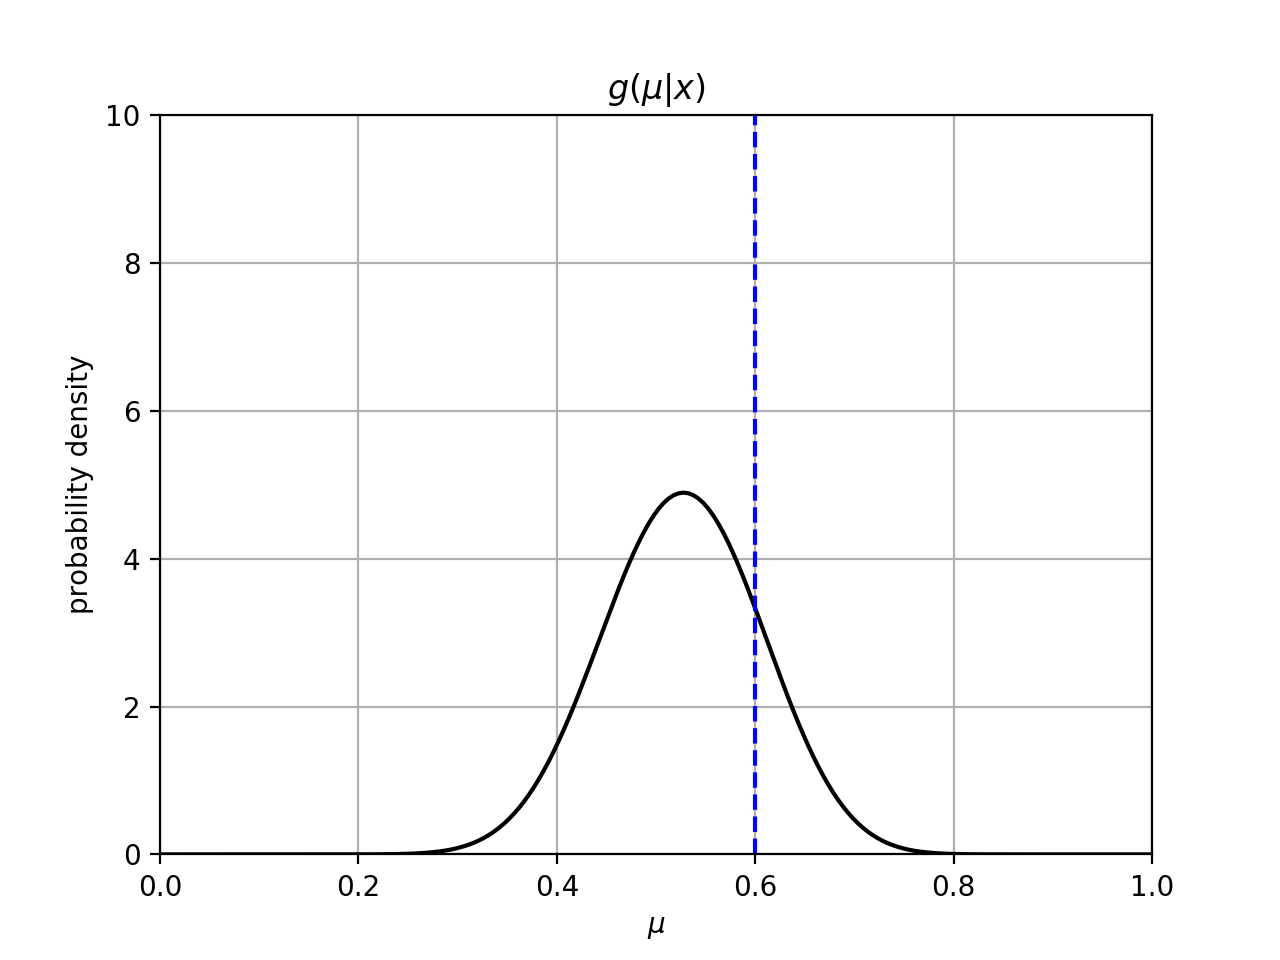

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ud = UpdateDist(ax, prob=mu, data=X, alpha=alpha, beta=beta)

anim = animation.FuncAnimation(fig, 
                               ud, 
                               frames=np.arange(size), 
                               init_func=ud.start, 
                               interval=500, 
                               blit=True, 
                               repeat=False)
plt.title('$g(\mu|x)$')
plt.ylabel('probability density')
plt.xlabel(r'$\mu$')
plt.show()

## Как работи?

### Използваме формулата на Бейс:

### $$g(\mu|x)=\frac{f_\mu(x)g(\mu)}{f(x)}$$


Където:

- $\mu$ е е параметър, който параметризира дистрибуциите, който според нас обяснява данните - нашата хипотеза

- $g(\mu)$ е нашата вяра колко са вероятни различните стойности на $\mu$. При *достатъчно* данни, началния избор не трябва да влияе на резултата

- $x$ са наблюдаваните данни */дадени/*

- $g(\mu|x)=P(\mu|x)$ e вероятността предполагаемият модел да обяснява данните $x$ */резултатат до момента/*

- $f_\mu(x)=P(x|\mu)$ е вероятността да наблюдаваме данните $X$, ако модела, който ги е генерирал е $f_\mu$ */смята се/*

- $f(x) = P(x)$ e вероятност да наблюдаваме $x$, независимо от стойността на $\mu$. Това се явява и нормализационна константа на числителя:
$$ f(x)=\int_\Omega f_\mu(x) d\mu $$




За горния пример, нека $s$ e броя успехи(1), а $f$ е броя неуспехи(0). Ако **вярваме**, че данните в X идват от процес на Бернули, то той се описва с

$$f_\mu(x) = P(x = (s, f) \mid H=\mu) = {s+f \choose s} \mu^s(1-\mu)^f$$

Нека изберем за начолно разпределение на $\mu \sim B(\alpha, \beta)$. За бета разпределението знаем, че 
- $B(1,1)$ e равномерно разпределение
- средното е $\alpha / (\alpha+\beta)$
- функцията на разпределение е
$$g(\mu) = {\mu^{\alpha-1}(1-\mu)^{\beta-1} \over B(\alpha,\beta)}$$

Така избрани, замесваме във формулата на Бейс

 $$ \begin{align}g(\mu|x)=P(\mu \mid x = (s, f)) &= \frac{P(s, f \mid \mu)P(\mu)}{\int P(s, f \mid \mu)P(\mu)d\mu}\\
                   & = {{{s+f \choose s} \mu^{s+\alpha-1}(1-\mu)^{f+\beta-1} / B(\alpha,\beta)} \over \int_{y=0}^1 {s+f \choose s} y^{s+\alpha-1}(1-y)^{f+\beta-1}  dy/ B(\alpha,\beta)} \\
                   & = {\mu^{s+\alpha-1}(1-\mu)^{f+\beta-1} \over B(s+\alpha,f+\beta)}, \\
\end{align}$$

**Много малко разпределения могат да се интегрират аналитично.** За това Бейсовите методи не са разглеждани до 90-те години. Но с ползването на MCMC методи, нещата изведнъж стават възможни:

## Монте Карло с Марковски вериги /MCMC/ в Бейсови изводи

- Целта е да се приближи разпределение, чрез **Монте Карло**

- Разпределението се представя като стационарното състояние на **Марковска верига**

Нека приложим върху генерираните данни в началото:


logp = -69.315, ||grad|| = 4: 100%|██████████| 6/6 [00:00<00:00, 667.49it/s]
100%|██████████| 4500/4500 [00:01<00:00, 2340.32it/s]


<IPython.core.display.Javascript object>


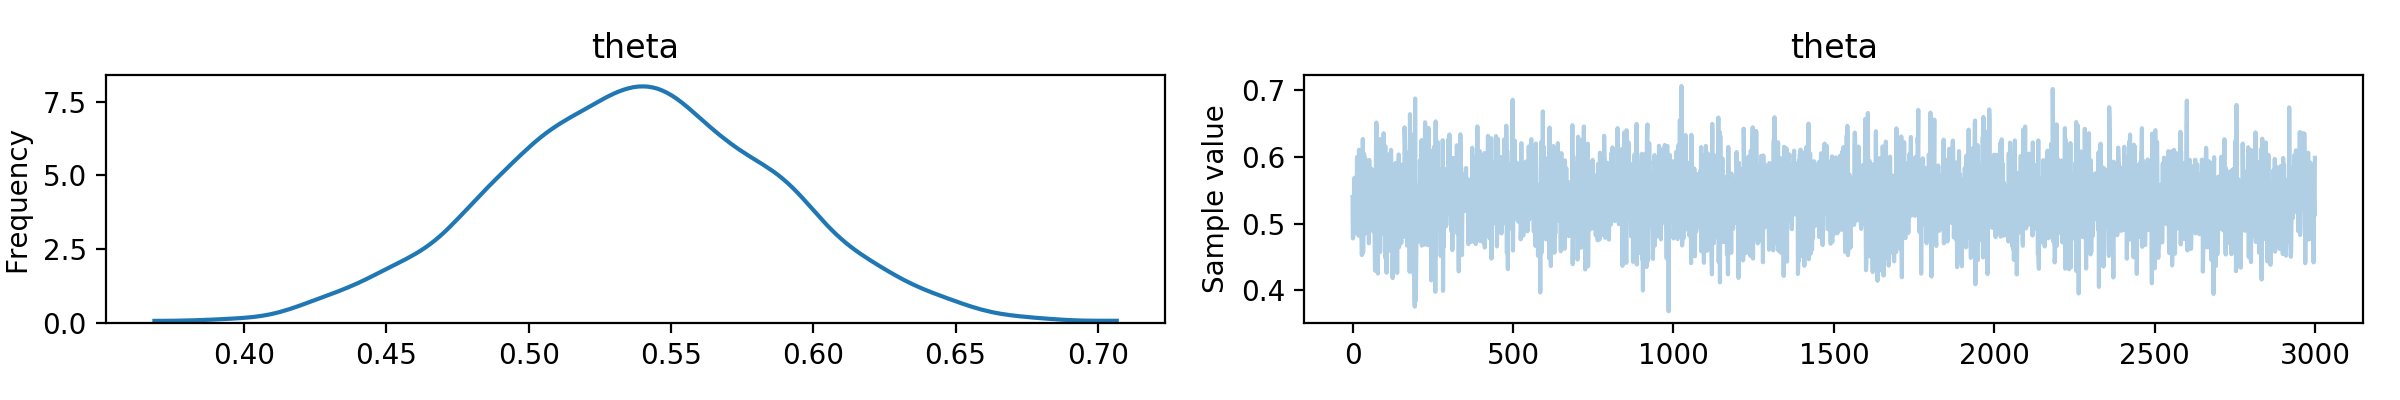

In [47]:
model = pm.Model()

with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta = pm.Beta('theta', alpha=alpha, beta=beta) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('data_a',
                          p=theta, 
                          observed=X)

    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(4000, step, start=start, progressbar=True) # draw posterior samples using slice sampling 
pm.traceplot(trace[1000:]);

### Пример 2:
Имаме двама тенесисти. А е победител в 50% отсрещите, а B 60%.

In [48]:
np.random.seed(9)
algo_a = sp.stats.bernoulli(.5).rvs(300) # 50% winning days
algo_b = sp.stats.bernoulli(.6).rvs(300) # 60% winning days

In [49]:
model = pm.Model()

with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta_a = pm.Beta('theta_a', alpha=1, beta=1) # prior
    theta_b = pm.Beta('theta_b', alpha=1, beta=1) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('observed A',
                          p=theta_a, 
                          observed=algo_a)
    
    data_b = pm.Bernoulli('observed B', 
                          p=theta_b, 
                          observed=algo_b)
    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(10000, step, start=start, progressbar=False) # draw posterior samples using slice sampling 

logp = -415.89, ||grad|| = 30.067: 100%|██████████| 6/6 [00:00<00:00, 949.37it/s]


<IPython.core.display.Javascript object>


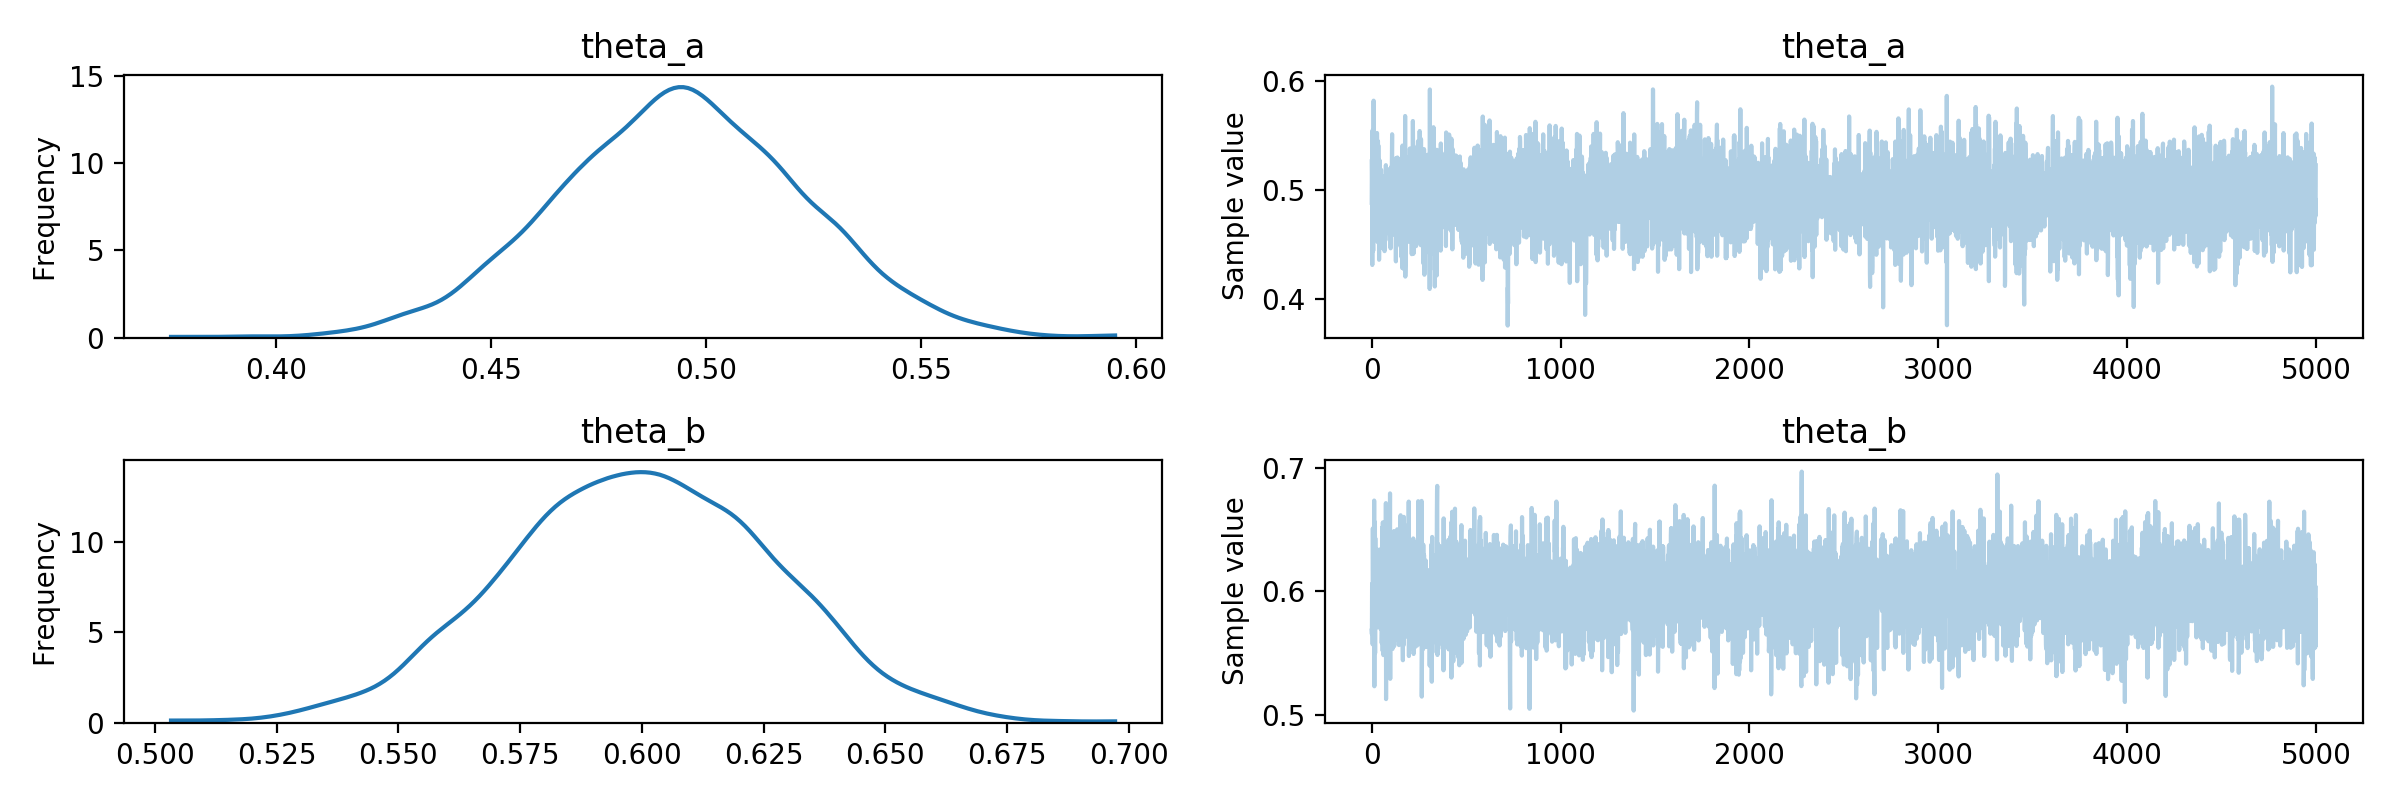

In [50]:
pm.traceplot(trace[5000:]);

Тестването на хипотеза е тривиално:

In [51]:
p_b_better_than_a = np.mean(trace['theta_a'] < trace['theta_b'])
print('P(B по-добър от A) = %.2f%%' % (p_b_better_than_a * 100))

P(B по-добър от A) = 99.53%


## Как работи?

- Искаме да следваме Марковска верига, чието стационарно разпределение $\pi$ да е желаната от нас вероятност
- Търсим $\pi T = \pi$
-  $\pi(x) T(x \to x') = \pi(x') T(x' \to x)$ уравнение на баланса
## Алгоритъм на Метрополис-Хастингс /Metropolis-Hastings/

- избираме произволна начални параметри

- от текущата x стойност преминаваме в нова $x'$ според $Q(x \to x')$
- приемаме $x'$ с вероятност $A(x \to x')$
- това ни дава

$$ T(x \to x') = Q(x \to x')A(x \to x') $$

Заместваме в ур. на баланса

$$ \pi(x) Q(x \to x')A(x \to x') = \pi(x') Q(x' \to x)A(x' \to x) $$

$$\frac{A(x \to x')}{A(x' \to x)}=\frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')} $$

Например може да изберем

$$ A(x \to x') = \frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')} $$

$$A(x' \to x) = 1$$

$$ A(x \to x') = \max (1, \frac{\pi(x') Q(x' \to x)}{ \pi(x) Q(x \to x')}) $$

$Q$ участва с отношение: *не ни е нужна интеграционната константа*